# Title: Image Classification using AWS Sagemaker


This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.


In [36]:
%%capture
!pip install smdebug torch 
!pip install pytorch 
!pip install torchvision

In [37]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import torch 
import torchvision
import os

from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile



## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.


In [38]:
#Fetch and upload the data to AWS S3
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"



In [39]:
# use default S3 bucket
bucket = sagemaker_session.default_bucket()

import os
# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket
bucket

'sagemaker-us-east-1-953953830980'

In [40]:
%%capture
!wget -a https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip


In [41]:
%%capture
!unzip -o dogImages.zip

In [42]:
%%capture
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [43]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256]),
}

role = sagemaker.get_execution_role()

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [44]:
#TODO: Create estimators for your HPs
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name = 'pytorch_dog_hpo',
    role=role,
    py_version='py3',
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.c5.xlarge"
    )

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [ ]:
# TODO: Fit your HP Tuner
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-953953830980/dogImages/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-953953830980/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-953953830980/output/'
tuner.fit({"training": "s3://sagemaker-us-east-1-953953830980/dogImages/"}, wait=True)# Remember to include your data channels

...................................................................................................................................................................................................................................................................................................................................................................................................................!


In [ ]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()#TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2021-12-12 12:38:37 Starting - Preparing the instances for training
2021-12-12 12:38:37 Downloading - Downloading input data
2021-12-12 12:38:37 Training - Training image download completed. Training in progress.
2021-12-12 12:38:37 Uploading - Uploading generated training model
2021-12-12 12:38:37 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.0033394403406322728',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch_dog_hpo-2021-12-12-11-54-05-403"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-953953830980/pytorch_dog_hpo-2021-12-12-11-54-05-403/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.


In [52]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [53]:
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}

#yperparameters = {"batch_size": "32", "lr": "0.0033394403406322728"}
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.c5.xlarge',
    entry_point="train_model.py",
    framework_version="1.8.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, 
    debugger_hook_config=debugger_config,
    rules=rules
)
estimator.fit({"training": "s3://" +str(bucket)+"/dogImages/"}, wait=True)

2021-12-12 13:21:32 Starting - Starting the training job...
2021-12-12 13:22:00 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2021-12-12 13:23:00 Starting - Preparing the instances for training......
2021-12-12 13:24:01 Downloading - Downloading input data.........
2021-12-12 13:25:26 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-12 13:25:41,794 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-12 13:25:41,796 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-12 13:25:41,805 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-12 13:25:42,420 sagemaker_pytorch_container.training INFO     Invoking us

In [54]:

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))


Training jobname: pytorch-training-2021-12-12-13-21-31-601
Region: us-east-1
[2021-12-12 13:42:33.450 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-12 13:42:33.460 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-953953830980/pytorch-training-2021-12-12-13-21-31-601/debug-output
[2021-12-12 13:42:33.706 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-12 13:42:34.725 datascience-1-0-ml-g4dn-xlarge-94fad2f4401e538ca1255dfa1e84:19 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer

In [57]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [58]:
# TODO: Plot a debugging output.

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


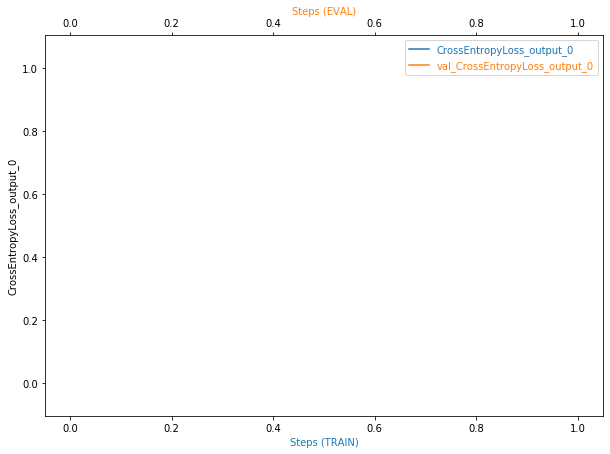

In [59]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [60]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-953953830980/pytorch-training-2021-12-12-13-21-31-601/rule-output


In [61]:
! aws s3 ls {rule_output_path} --recursive

2021-12-12 13:40:56     375535 pytorch-training-2021-12-12-13-21-31-601/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-12-12 13:40:55     223448 pytorch-training-2021-12-12-13-21-31-601/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-12-12 13:40:50        192 pytorch-training-2021-12-12-13-21-31-601/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-12-12 13:40:50        200 pytorch-training-2021-12-12-13-21-31-601/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-12 13:40:50       1922 pytorch-training-2021-12-12-13-21-31-601/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-12-12 13:40:50        127 pytorch-training-2021-12-12-13-21-31-601/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-12 13:40:50        199 pytorch-training-2021-12-12-13-21-31-601/rule-output/ProfilerReport/profiler-output/profiler-re

In [62]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-953953830980/pytorch-training-2021-12-12-13-21-31-601/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-953953830980/pytorch-training-2021-12-12-13-21-31-601/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-953953830980/pytorch-training-2021-12-12-13-21-31-601/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-953953830980/pytorch-training-2021-12-12-13-21-31-601/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-953953830980/

In [63]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [64]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [65]:
model_location=estimator.model_data

In [66]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [67]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [74]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='inference.py',py_version='py3',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor) 

In [75]:
# TODO: Deploy your model to an endpoint

predictor=pytorch_model.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge") #  Add your deployment configuration like instance type and number of instance

-----!

In [76]:
with open("dogImages/test/010.Anatolian_shepherd_dog/Anatolian_shepherd_dog_00695.jpg", "rb") as f:
    payload = f.read()
    
type(payload)

bytes

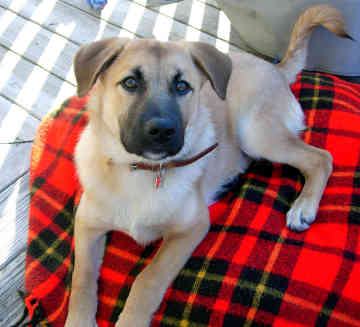

In [77]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [78]:
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})

In [79]:
response

[[-14.225837707519531,
  -7.339566230773926,
  -13.18785572052002,
  0.04840175807476044,
  -2.3994641304016113,
  -3.72025728225708,
  -3.5654656887054443,
  -3.526655673980713,
  -12.702816009521484,
  0.8098011612892151,
  -2.8346781730651855,
  -3.705226421356201,
  -13.448657035827637,
  -4.34988260269165,
  -8.346578598022461,
  -3.404266595840454,
  -8.087323188781738,
  -6.2725138664245605,
  -7.700551986694336,
  -1.4524914026260376,
  -12.482895851135254,
  -5.263796806335449,
  -7.002789497375488,
  -4.999546051025391,
  -8.46806812286377,
  -13.450260162353516,
  -4.406876564025879,
  -10.78038215637207,
  -7.545679569244385,
  -8.216343879699707,
  -1.2510907649993896,
  -6.495027542114258,
  -12.823431968688965,
  -3.7925500869750977,
  -10.983381271362305,
  -11.460634231567383,
  -4.118917942047119,
  -7.014723777770996,
  -3.168347120285034,
  -4.328019142150879,
  -4.2784624099731445,
  -11.115388870239258,
  -1.737323522567749,
  -5.348454475402832,
  -2.471158266067

In [80]:
#Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()